# Lotka-Volterra Model with `pfmvn`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax

In [3]:
import pfjax as pf
from pfjax.particle_filter import particle_filter, particle_loglik, particle_resample_mvn
from pfjax import proj_data, LotVolModel
import pfjax.sde
# import pfjax.particle_filter_mvn as pfmvn

from pfjax import stoch_opt, get_sum_lweights, get_sum_lweights_mvn

## Simulate and Plot Data

Plotting the observations of the state (latent variables) as well as the observations. The latent observations are the smooth lines given below and the observations are the slightly more jagged lines.

In [12]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25 # low noise = 0.1
tau_l = 0.25 # low noise = 0.1

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 2 # 1, 2, 4, 8, 16
n_obs = 50
lotvol_model = LotVolModel(dt, n_res) 

key = random.PRNGKey(0)
key, subkey = random.split(key)

In [13]:
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)

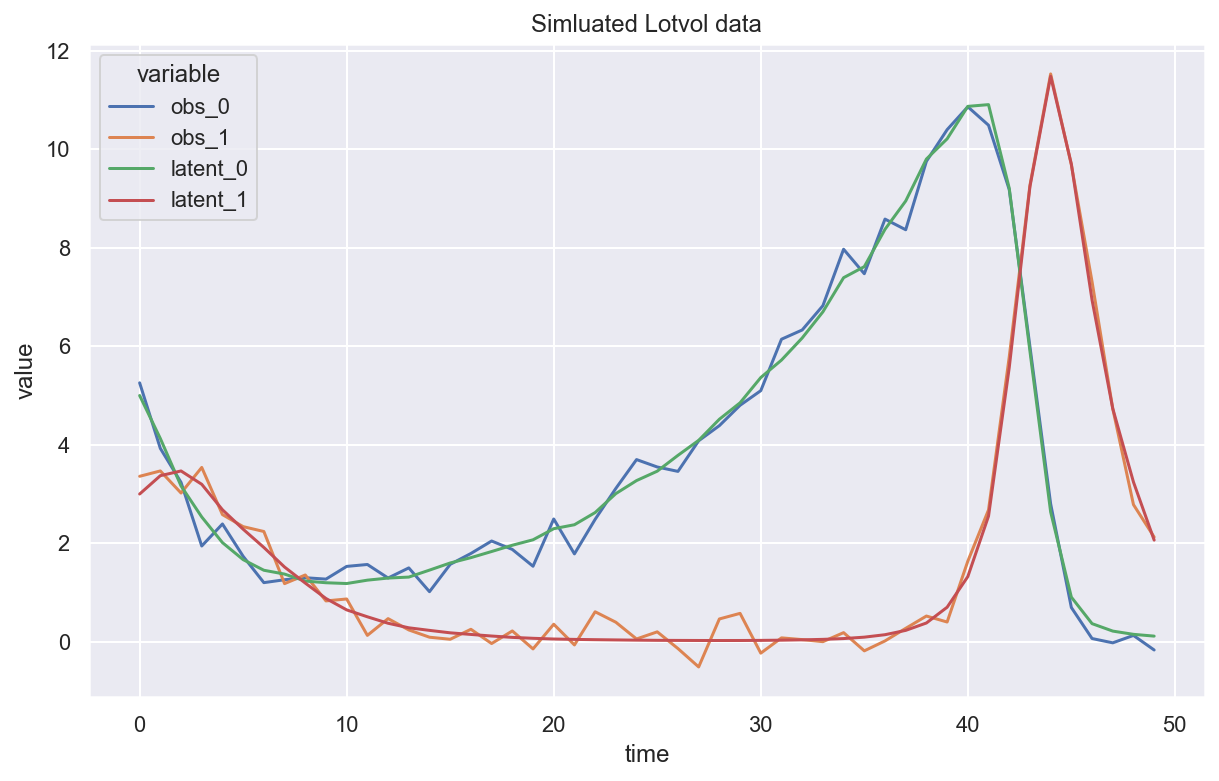

In [6]:
def make_df(data_arr, labels):
    """
    FIXME: Only works with resolution size 1
    Make dataframe for Seaborn plotting
    data_arr = [y_meas, x_state]
    labels = ["obs_0", "obs_1", "latent_0", "latent_1"]
    """
    y_meas = data_arr[0]
    x_state = data_arr[1]
    df = pd.DataFrame(y_meas) 
    df.columns = labels[:2]
    df[labels[2]] = jnp.exp(jnp.squeeze(x_state)[:, 0])
    df[labels[3]] = jnp.exp(jnp.squeeze(x_state)[:, 1])
    df["time"] = df.index
    return df

true_data = make_df([y_meas, x_state],
                    labels=["obs_0", "obs_1", "latent_0", "latent_1"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
sns.lineplot(data=pd.melt(true_data, id_vars = "time"), 
             x="time", y="value", hue="variable")\
    .set_title("Simluated Lotvol data");

## Particle Filter with MVN Approx.

$$
\ell(\theta \mid x_{0:T}, y_{0:T}) = \log p(y_0 \mid x_0, \theta) + \sum_{t=1}^T \log p(y_t \mid x_t, \theta) + \log p(x_t \mid x_{t-1}, \theta).
$$

In [7]:
theta_lims = np.array([[0.8, 1.2], [.75, 1.2], [3.5, 4.5], [0.8, 1.2],
                       [.05, .2], [.05, .2], [.1, .5], [.1, .5]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
# n_pts = 100

(250, 1, 2)


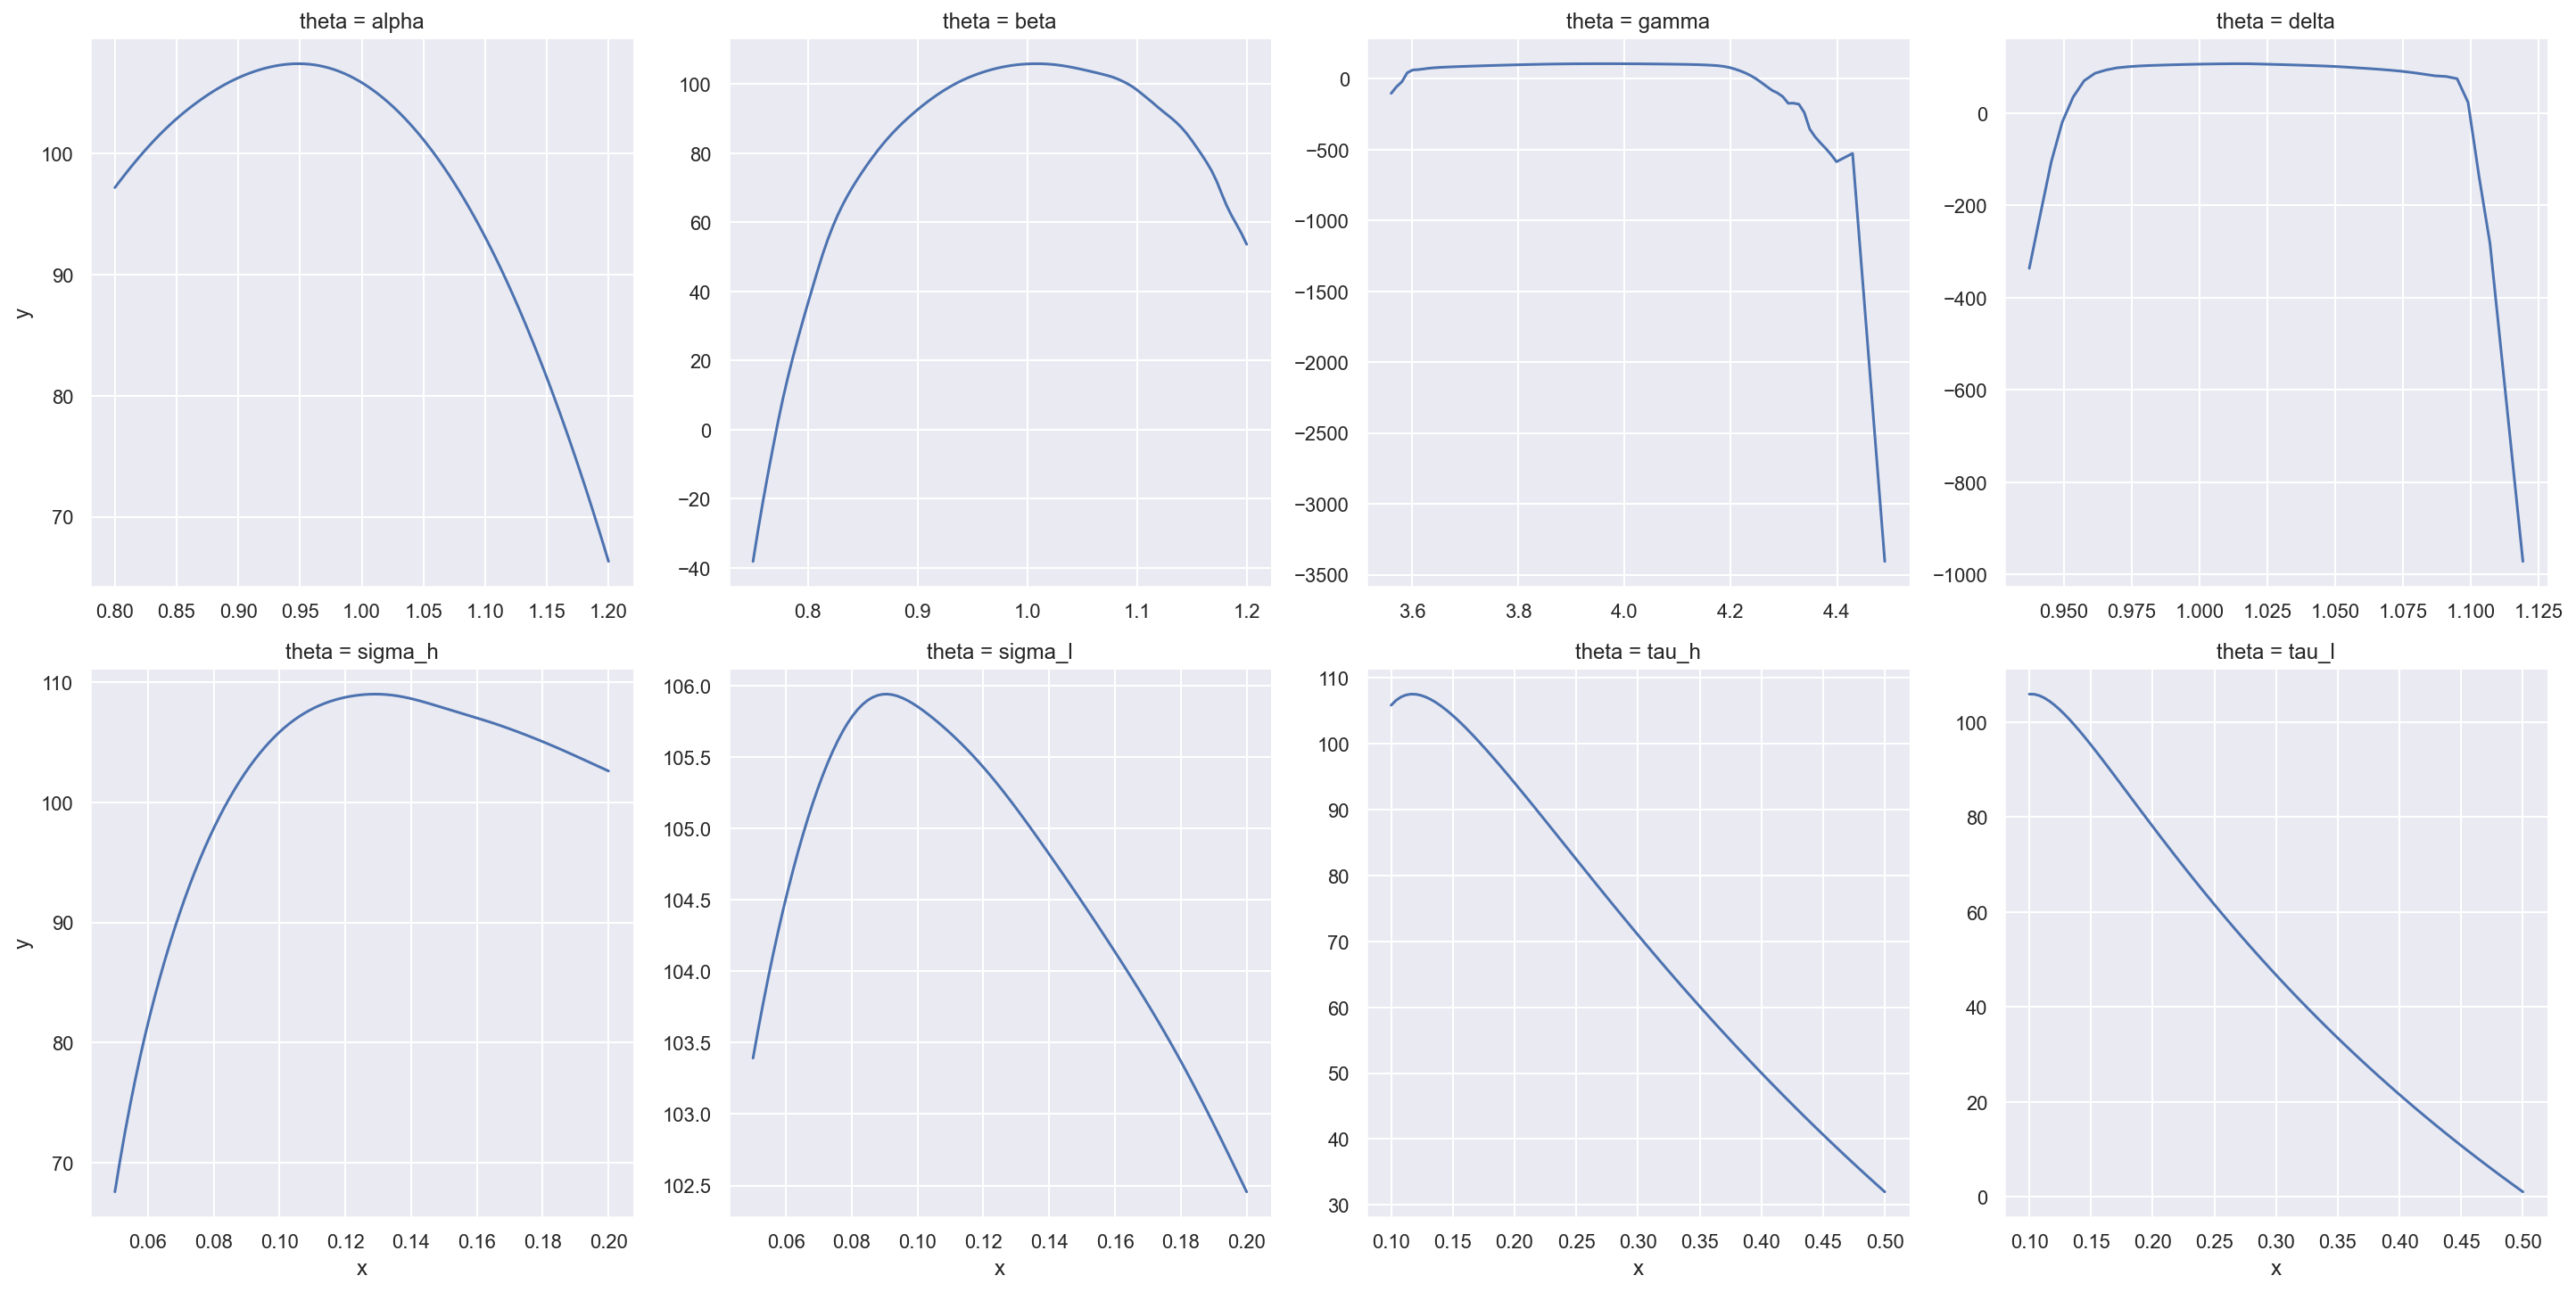

In [16]:
n_particles = 250

@jax.jit
def lotvol_pflik(theta):
    temp = particle_filter(theta=theta, model=lotvol_model, 
                           y_meas=y_meas, 
                           n_particles=n_particles, key=key,
                           particle_sampler = particle_resample_mvn)
    return particle_loglik(temp['logw'])

plot_df = proj_data(fun = lotvol_pflik, theta = theta, theta_lims = theta_lims, 
                    theta_names = theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
);

### Bootstrap Particle Filter

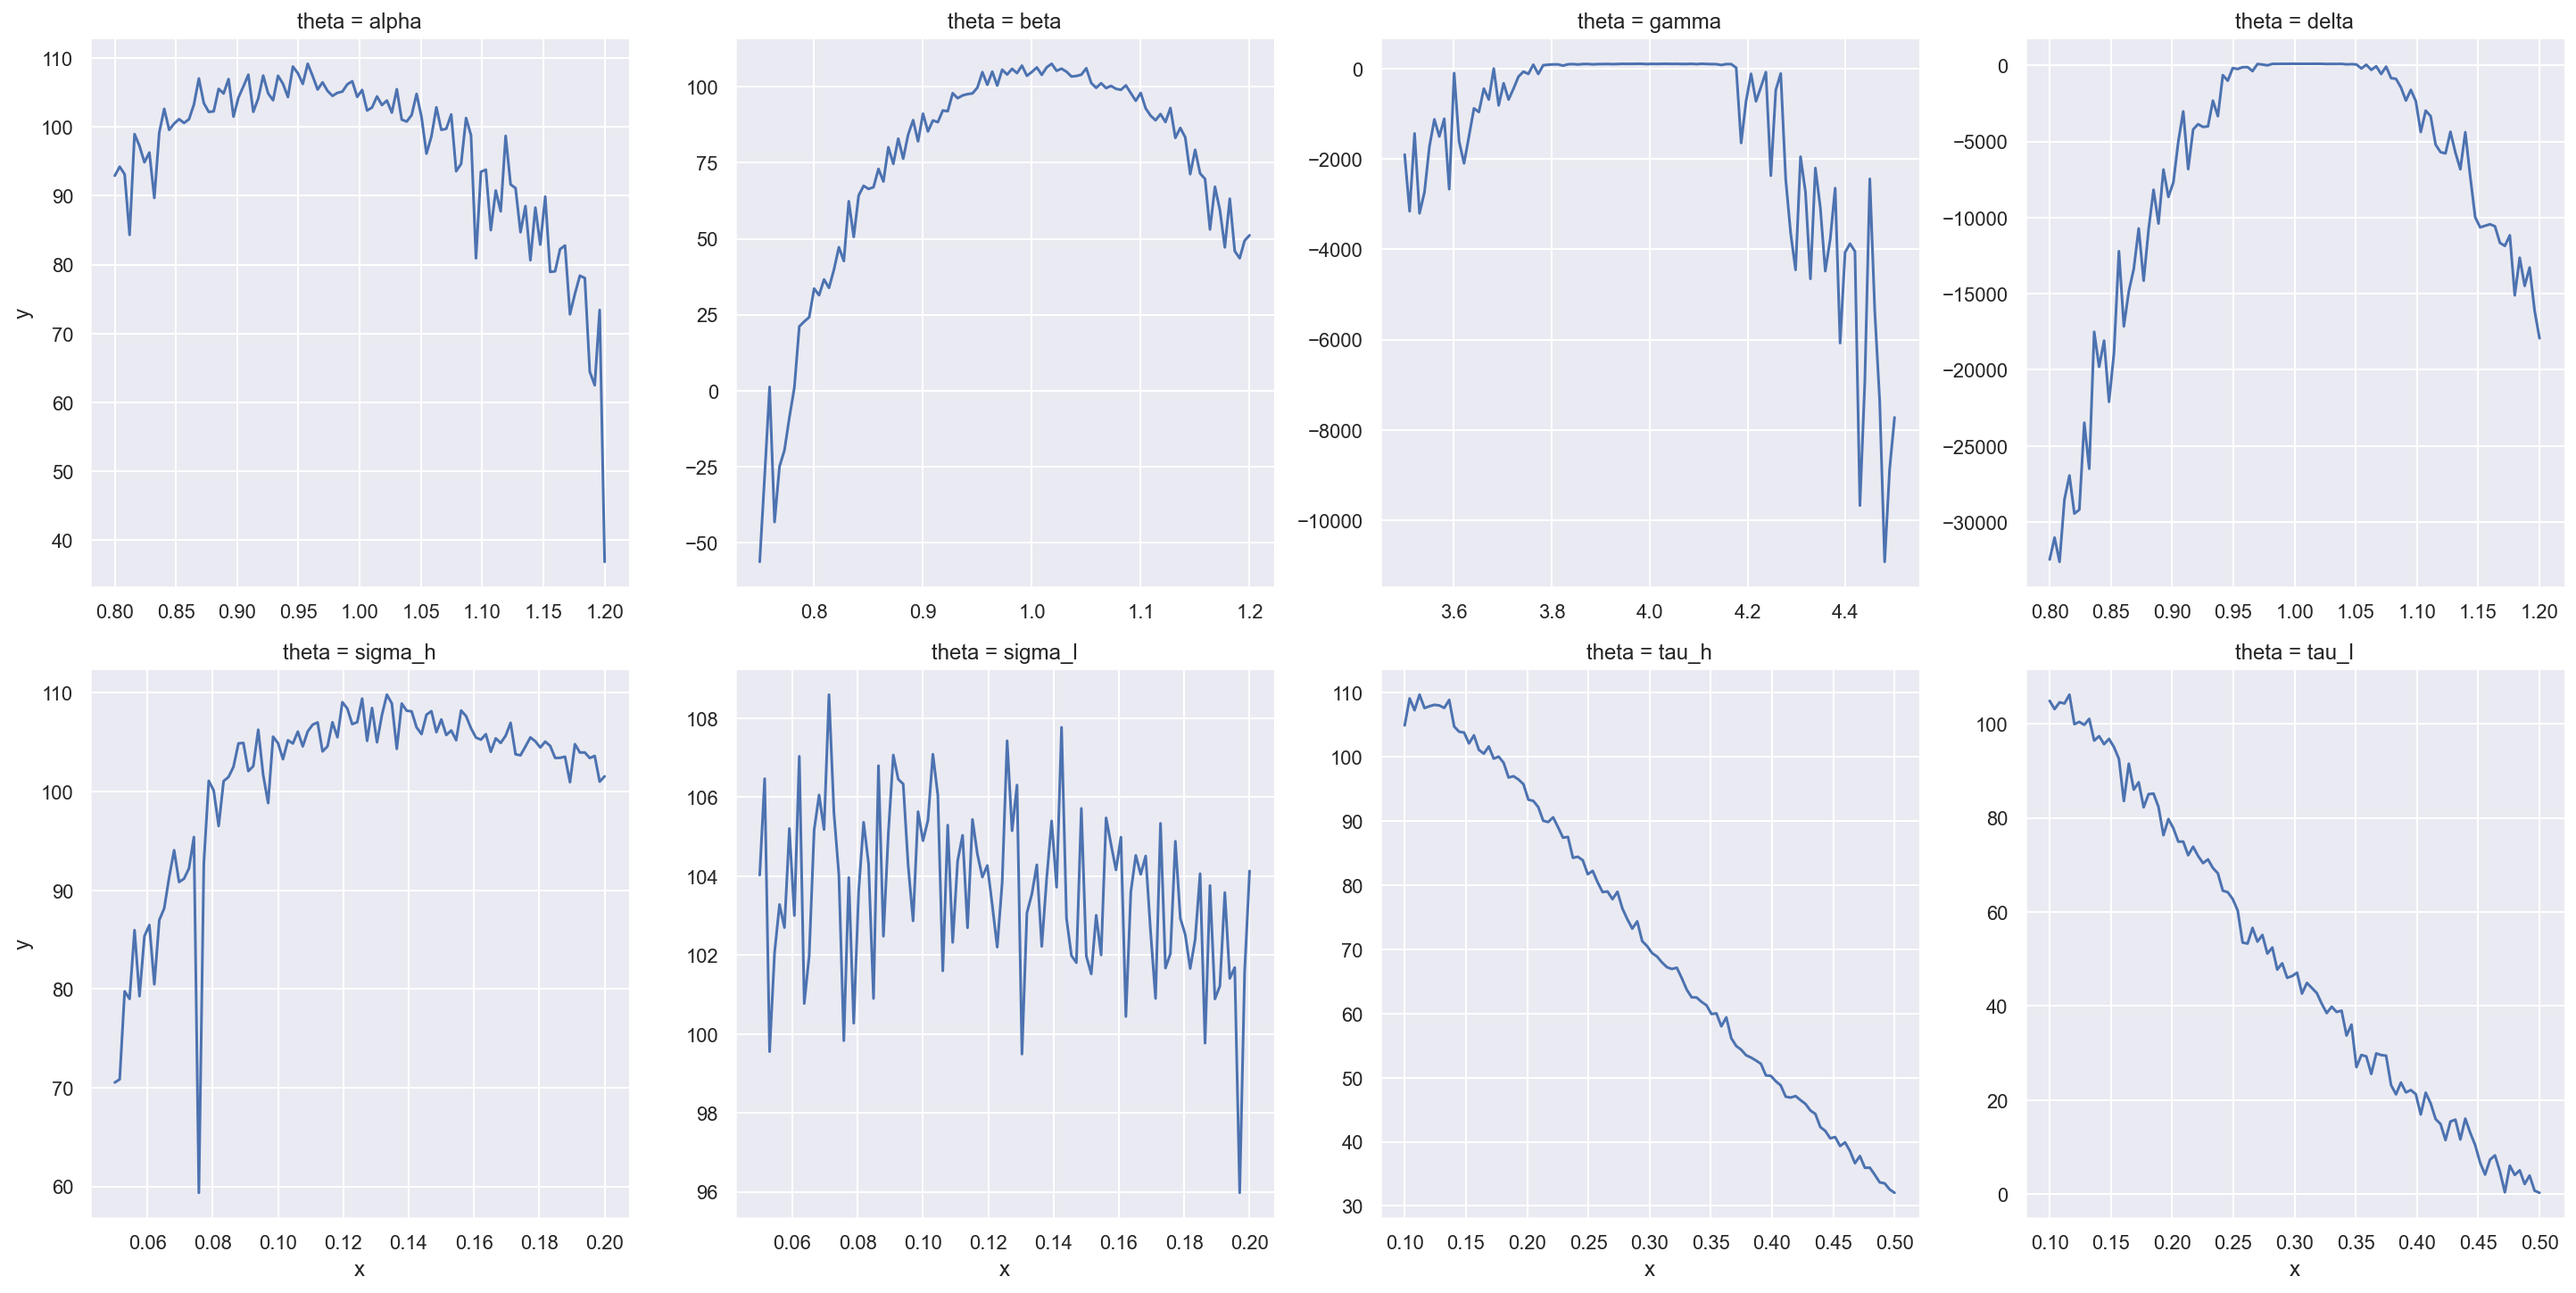

In [17]:
@jax.jit
def lotvol_pflik(theta):
    temp = particle_filter(theta=theta, 
                           model=lotvol_model, y_meas=y_meas,
                           n_particles=n_particles, key=key)
    return particle_loglik(temp['logw'])

plot_df = proj_data(fun = lotvol_pflik, theta = theta, 
                    theta_lims = theta_lims, 
                    theta_names = theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
);

## Experimental Notes

- The MVN approximation makes the log-likelihood **much** smoother. This is noticable in the optimization, for example the bootstrap particle filter diverges for `{learning_rate = 1e-4, n_particles=1000}`, but the MVN approximation is able to converge with the same learning rate and half the particles (500). This is with the initial values as the true paramters. 


## Jit VS No-Jit

Timing using `%%timeit` with 7 iterations. 

- MLE (50 particles): 
    - Full jit time: 9.5 s ± 327 ms
    - No jit time: 10.2 s ± 896 ms
    

- Posterior stoch-opt (100 particles, 1000 iterations, 1e-5 lr): 
    - Full Jit Time: 12.6 s ± 1.13 s
    - No-jit time: 11.9 s ± 1.04


- Hessian calculation (1000 particles): 
    - Full jit time: 24.7 s ± 1.22
    - No jit: 27.9 s ± 4.8 s

In [15]:
# %%timeit
start =time.perf_counter()

params = stoch_opt(model = lotvol_model, 
                   params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.2, 0.2]), 
                   grad_fun = get_sum_lweights_mvn, 
                   y_meas = y_meas, key=key, 
                   n_particles = 100,
                   learning_rate=1e-5, 
                   iterations=1000,
                   mask=np.array([1,1,1,1,1,1,0, 0]))

print("Time: {0}".format(time.perf_counter() - start))
print("Estimated params: {0}".format(list(round(params, 1))))
print("True params: {0}".format(list(theta)))

(100, 2, 2)
Time: 14.017867856999999
Estimated params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.2, 0.2]
True params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.25, 0.25]


(1000, 2, 2)
postitive semi-def:  False


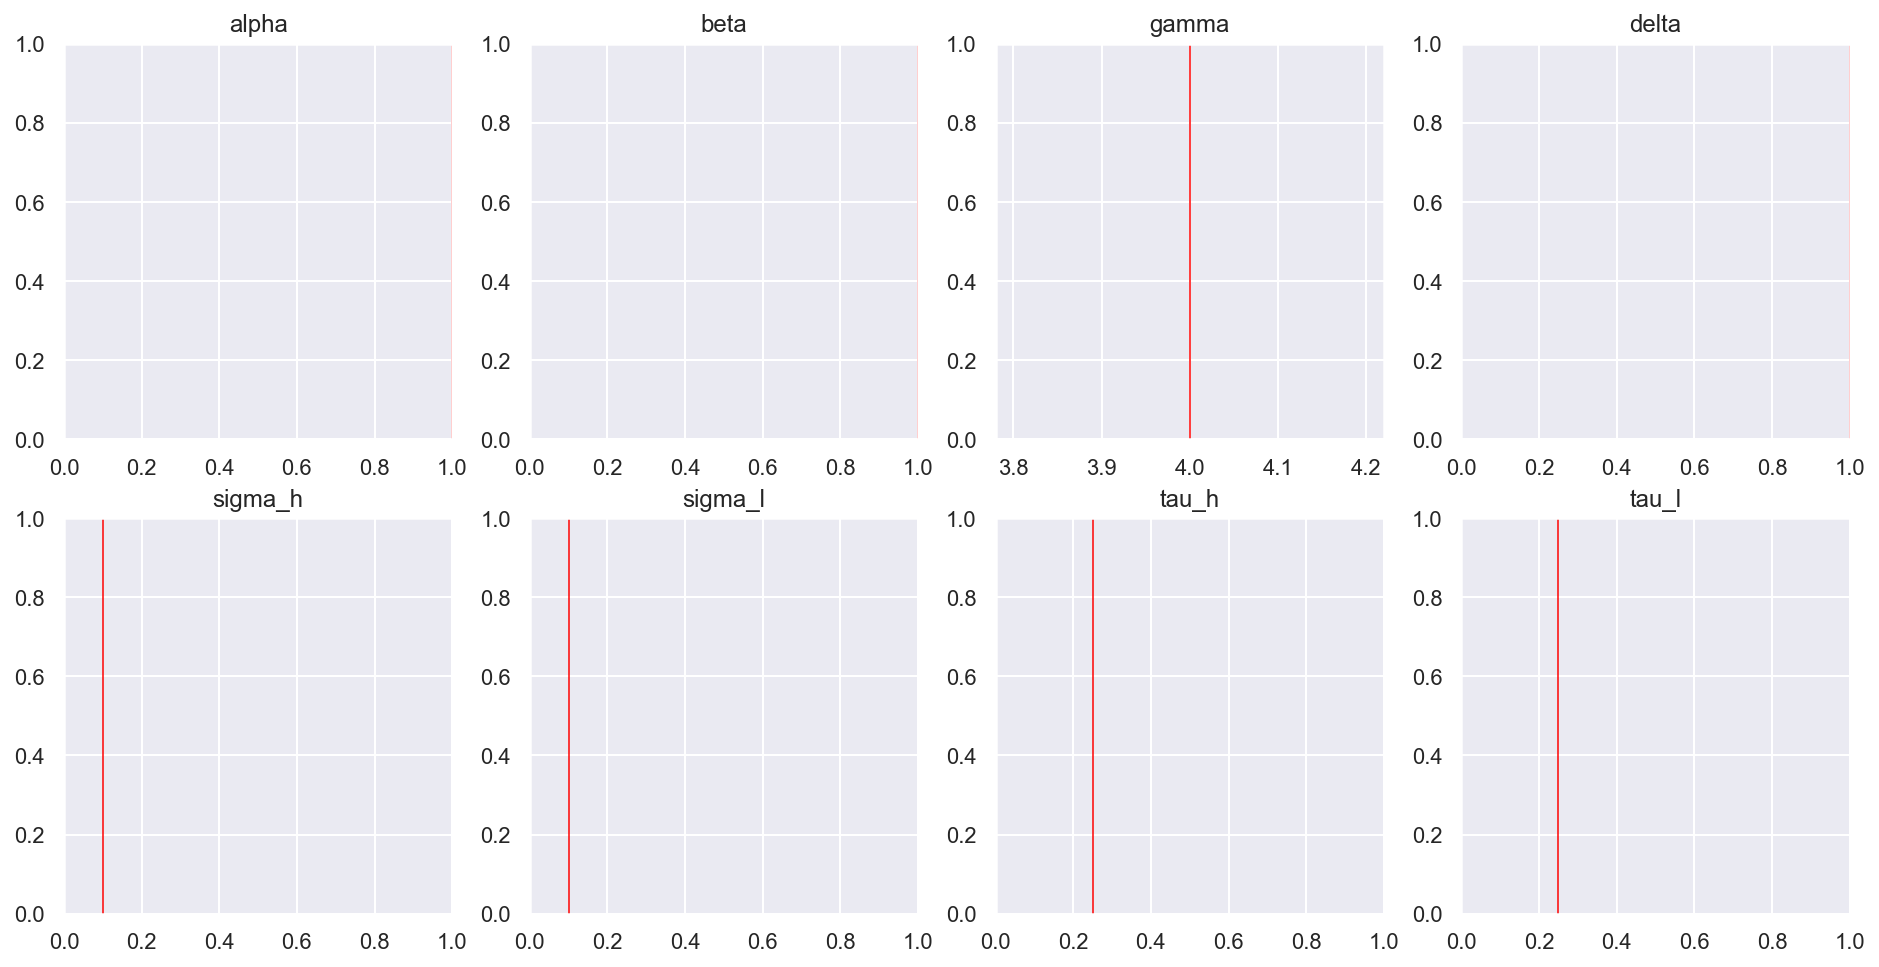

In [28]:
hessian = jax.jacfwd(jax.jacrev(get_sum_lweights_mvn))

# should increase the number of particles here, since we want a one-time accurate approx. of the loglik
hess = hessian(params,
               key, 
               n_particles=1000, 
               y_meas=y_meas, 
               model=lotvol_model)

theta_hat = params
var_hat = jnp.linalg.inv(hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(-var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))# , sharey = True)
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]

for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

## Presentation: 

- [ ] Create Jupyter Notebook with stochastic optimization results using the MVN filter for as many as possible settings in Michelle's Lotka-Volterra example.

- [ ]  Please try to make your `particle_filter_mvn()` function jittable and gradable.  I think this means removing as many `if` statements as possible.  Those that remain should be replaced by `lax.cond()`.

- [ ] Check that things still work with a few minor changes I've made to the `LotVolModel` class.  In particular, the last of the `n_res` latent variables per time step line up with the observation, whereas it used to be the first.  Also, the prior is now mathematically correct (I'd previously omitted the trunctation), but I haven't checked the calculations. 

- [ ] Note that in addition to mode finding, you can estimate the fisher information by taking the Hessian of the stochastic objective function at the mode.  Approximate Bayesian inference can then be conducted by taking the parameters to be multivariate normal with mean at the mode and variance at the inverse of the fisher information

- [ ] Approximate Fisher information matrix (negative inverse in the variance of the MLE). 

## Resolution Size = 1

Using Michelle's data I can run stoch_opt on all parameters without masking, but the negative Hessian is not positive semi-definite.

In [28]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25 # low noise = 0.1
tau_l = 0.25 # low noise = 0.1
theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

key = random.PRNGKey(0)

dt = 0.1
n_res = 1
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

_y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

data = pd.read_csv("lv_low.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

(100, 1, 2)


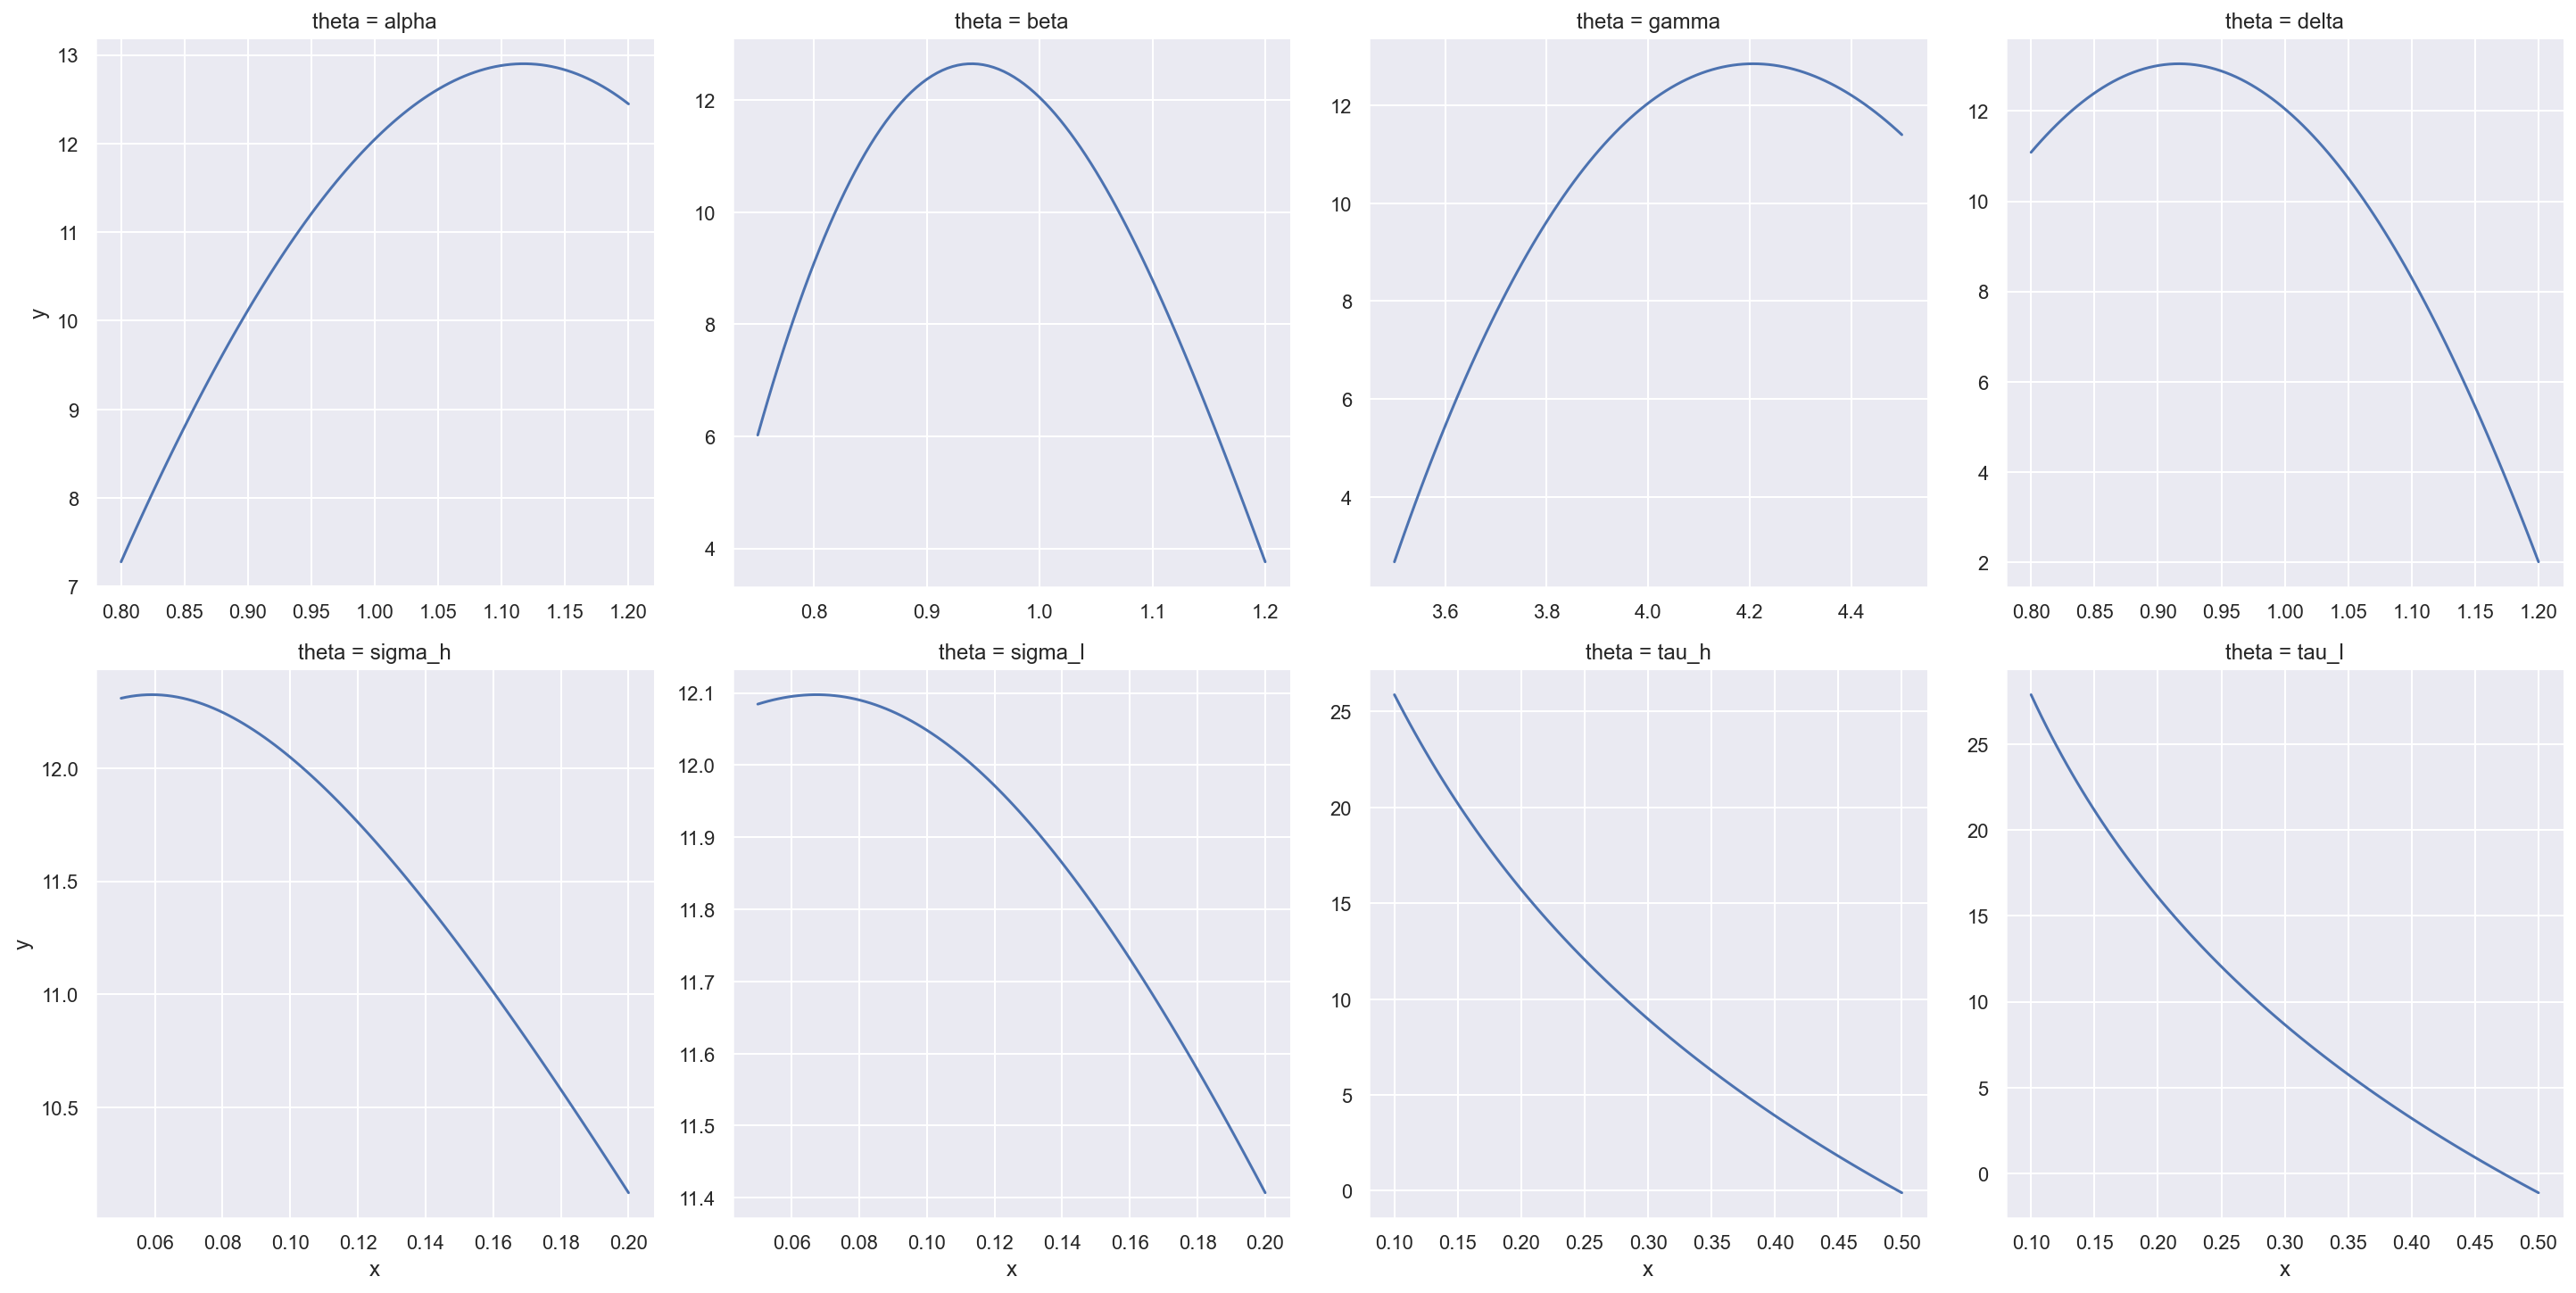

In [29]:
theta_lims = np.array([[0.8, 1.2], [.75, 1.2], [3.5, 4.5], [0.8, 1.2],
                       [.05, .2], [.05, .2], [.1, .5], [.1, .5]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]

n_particles = 100

@jax.jit
def lotvol_pflik(theta):
    temp = particle_filter(theta=theta, 
                           model=lotvol_model, 
                           y_meas = y_meas,
                           n_particles=n_particles,
                           particle_sampler = particle_resample_mvn,
                           key=key)
    return particle_loglik(temp['logw'])

plot_df = proj_data(fun = lotvol_pflik, theta = theta, 
                    theta_lims = theta_lims, 
                    theta_names = theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
);

In [30]:
params = stoch_opt(model = lotvol_model, 
                   params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), 
                   grad_fun = get_sum_lweights_mvn, 
                   y_meas = y_meas, 
                   key=key, 
                   n_particles = 100,
                   learning_rate=1e-5, 
                   iterations=1000,
                   mask=np.array([1,1,1,1,1,1,1,1]))
params

(100, 1, 2)


/Users/jonny/anaconda3/envs/kaggle/lib/python3.7/site-packages/jax/interpreters/xla.py:842: UserWarning: Some donated buffers were not usable: f32[8]{0}
  ", ".join(unused_donations)))


DeviceArray([0.9899864 , 1.0100136 , 3.9899864 , 1.0100136 , 0.1098787 ,
             0.0947207 , 0.26001358, 0.26001358], dtype=float32)

(10000, 1, 2)
postitive semi-def:  False


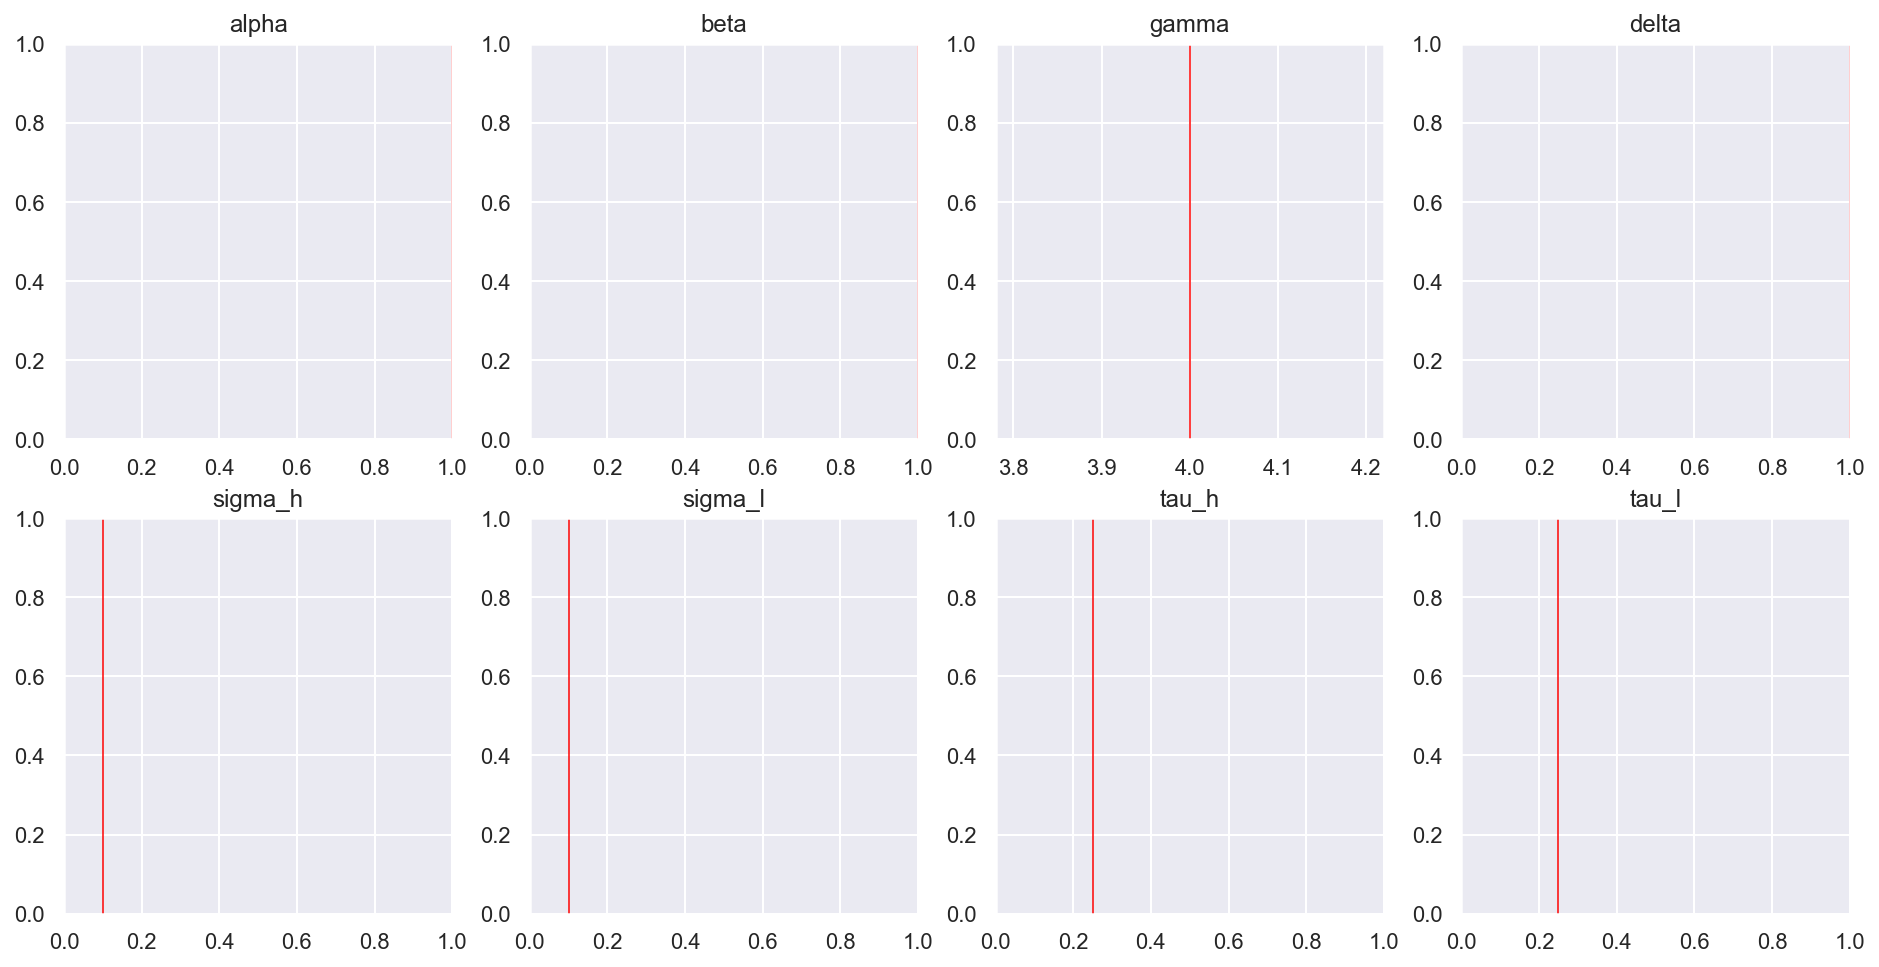

In [32]:
hessian = jax.jacfwd(jax.jacrev(get_sum_lweights_mvn))
hess = hessian(params,
               key, 
               n_particles=1000, 
               y_meas=y_meas, 
               model=lotvol_model)

theta_hat = params
var_hat = jnp.linalg.inv(hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(-var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))# , sharey = True)
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

# TESTS ---

In [13]:
hessian = jax.jacfwd(jax.jacrev(pfmvn.get_sum_lweights_mvn))

# should increase the number of particles here, since we want a one-time accurate approx. of the loglik
hess = hessian(params,
               key, 
               n_particles=1000, 
               y_meas=y_meas, 
               model=lotvol_model)

theta_hat = params
var_hat = jnp.linalg.inv(hess)

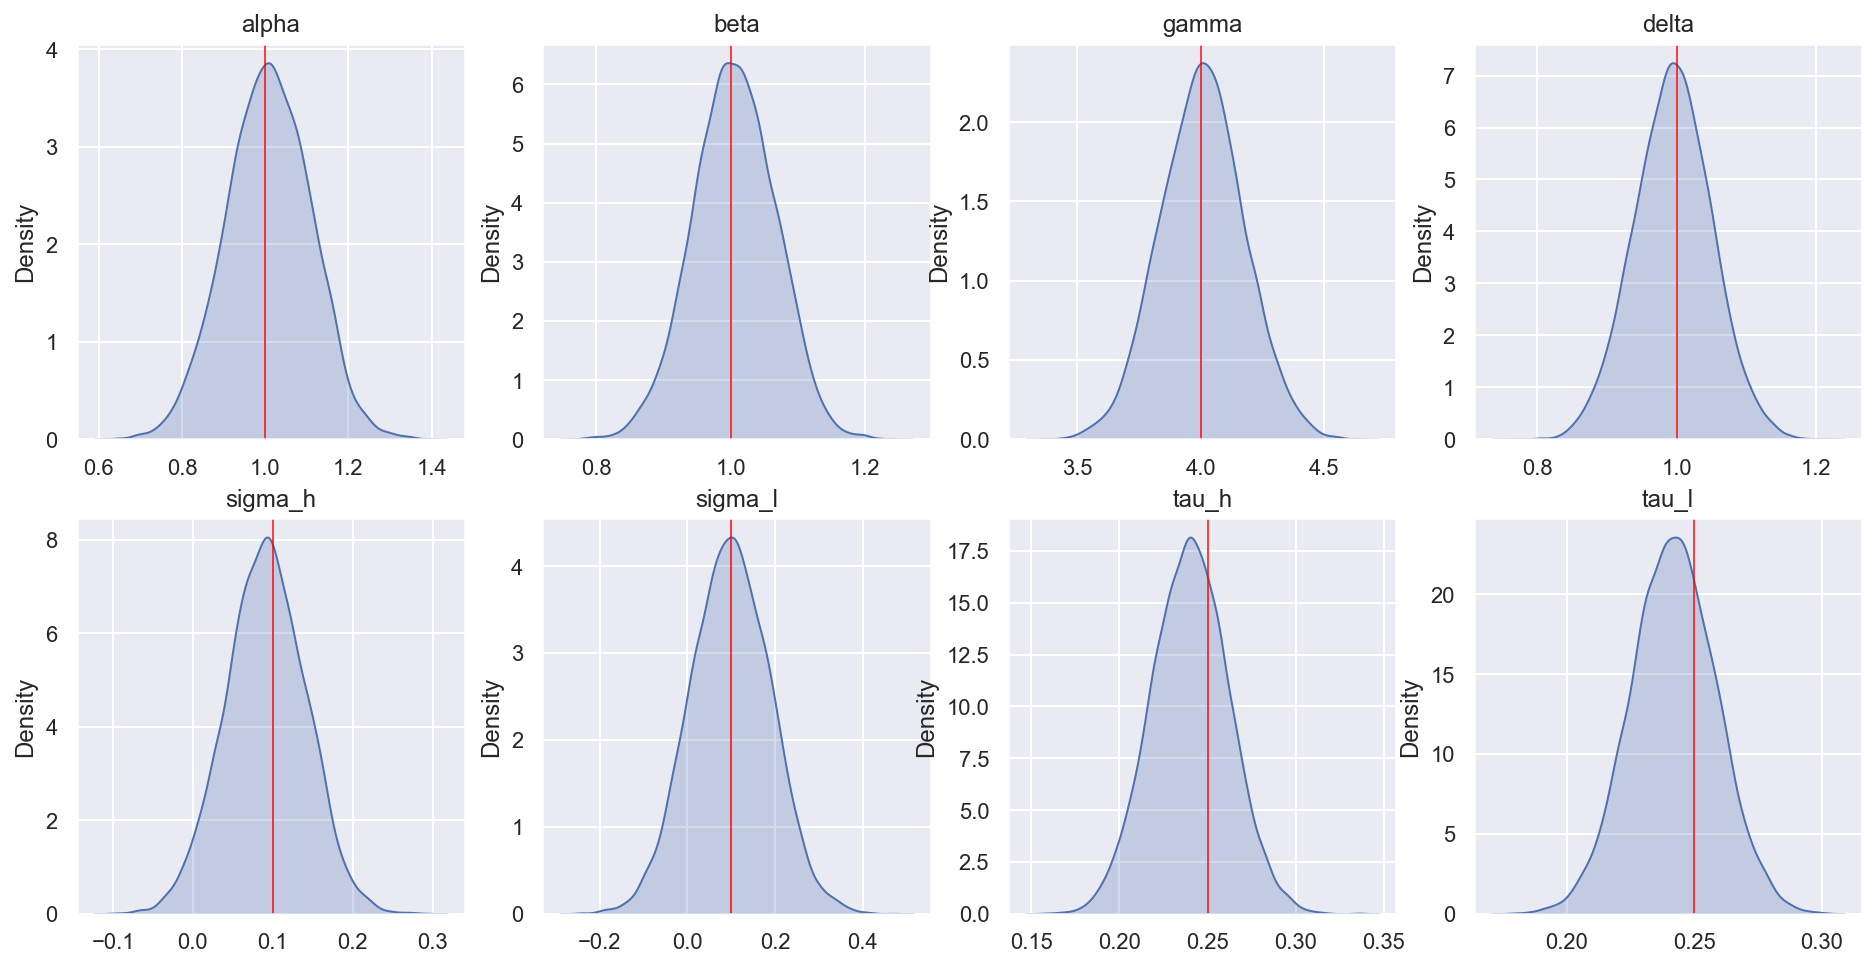

In [14]:
mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))# , sharey = True)
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]

for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

## Laplace Approximation - Test

- Define priors: $\pi(\theta)$
- Construct posterior
- Find theta hat argmax(posterior)

**Dont understand**: Fisher information is the negative Hessian of the log-likelihood, which is the variance of the score function, but the score function is the first derivative of the log-likelihood. Alternatively, we can approximate the log-likelihood with a Laplace approximation for which we have the inverse of the Hessian as the variance parameter. So the variance of the log-likelihood and the variance of the Score function are the same thing? Or is this only if the log-likelihood is evaluated at the maxinimum (MLE)?

### TODO

- Fix prior to use JAX sampling and not Scipy/Numpy sampling
- Make sure I am managing the keys properly in this notebook. Should I recreate the keys everytime  they are used? That essentially means deleting keys every time they are used 

In [10]:
from jax.scipy.stats import multivariate_normal 
from jax import random

prior_means = theta
prior_cov = jnp.diag(theta)

def prior(x): 
    # will have to change this to use Jax sampling
    return multivariate_normal.pdf(
    x, prior_means, prior_cov)

In [14]:
# %%timeit
start = time.perf_counter()
params, so, grads = stoch_opt(lotvol_model,
                              params=jnp.array(
                                  [1., 1., 4., 1., 0.1, 0.1, 0.25, 0.25]),
                              #   params=jnp.array(np.random.random(len(theta))*0.01),
                              grad_fun=pfmvn.log_posterior,
                              y_meas=y_meas, key=key,
                              learning_rate=1e-5, iterations=1000,
                              n_particles=100,
                              mask=np.array([1, 1, 1, 1, 1, 1, 1, 1]),
                              prior=prior)
print("Time: {0}".format(time.perf_counter() - start))
# print("Estimated params: {0}".format(list(round(params, 1))))
# print("True params: {0}".format(list(theta)))


Time: 12.18306301900003


In [15]:
%%timeit
# hessian: 
hessian = jax.jacfwd(jax.jacrev(pfmvn.log_posterior))

# should increase the number of particles here, since we want a one-time accurate approx. of the loglik
start = time.perf_counter()
hess = hessian(params, key, 
               n_particles=1000, 
               y_meas=y_meas, 
               model=lotvol_model, 
               prior=prior)
print("Time: {0}".format(time.perf_counter() - start))

theta_hat = params
var_hat = jnp.linalg.inv(hess)

Time: 34.08387946099998
Time: 25.799432801000023
Time: 26.936572599999977
Time: 25.45797890900002
Time: 23.96301673800002
Time: 23.65608342400003
Time: 23.699931765999963
Time: 23.666503850000026
24.7 s ± 1.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
n_post_samples = 2000
posterior_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(n_post_samples, ))

# find 95% credible intervals
theta_U = jnp.quantile(posterior_samples, q=0.95, axis=0)
theta_L = jnp.quantile(posterior_samples, q=0.05, axis=0)

round(theta_L, 2), round(theta_U, 2)

theta_L = jnp.array(list(map(lambda x: max(x, 1e-4), theta_L))) # trickery to remove negative values from lower bound

(DeviceArray([ 0.84      ,  0.94      ,  3.59      ,  0.90999997,
              -0.03      , -0.08      ,  0.25      ,  0.22      ],            dtype=float32),
 DeviceArray([0.93, 1.04, 4.23, 1.05, 0.03, 0.14, 0.35, 0.31], dtype=float32))

In [22]:
# forward simulate data with lower confidence interval:
x_init_L = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                    theta=theta_L,
                                    key=subkey)

y_meas_L, x_state_L = simulate(lotvol_model,
                               n_obs,
                               x_init_L,
                               theta_L,
                               subkey)
lower_bound = make_df([y_meas_L, x_state_L], 
                      labels = ["obs_0", "obs_1", "latent_0", "latent_1"])

# forward simulate data with upper confidence interval:
x_init_U = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                    theta=theta_U,
                                    key=subkey)

y_meas_U, x_state_U = simulate(lotvol_model,
                               n_obs,
                               x_init_U,
                               theta_U,
                               subkey)
upper_bound = make_df([y_meas_U, x_state_U], 
                      labels = ["obs_0", "obs_1", "latent_0", "latent_1"])

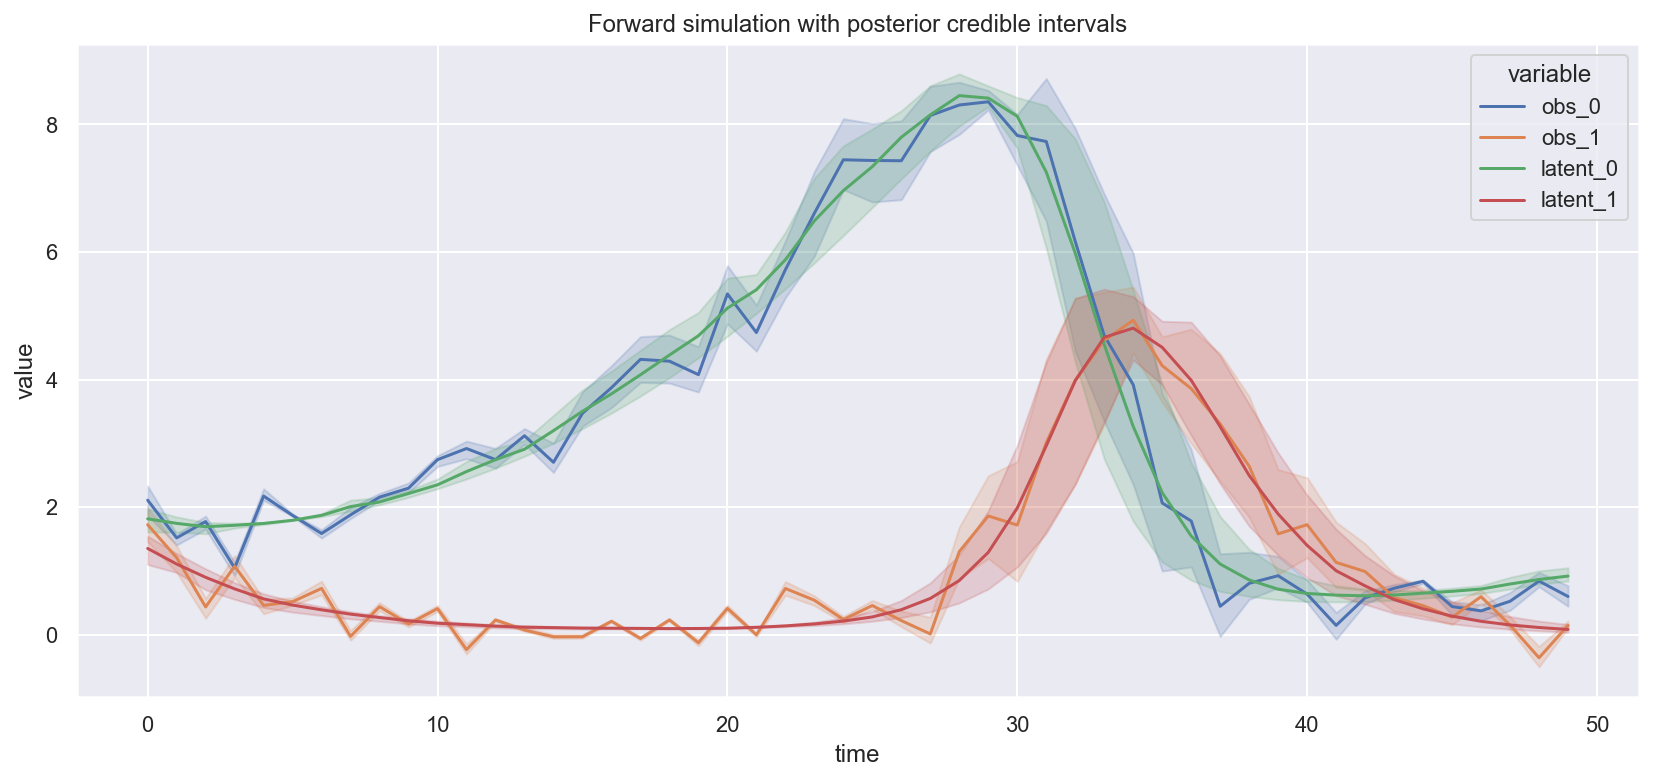

In [23]:
all_data = pd.concat([lower_bound, upper_bound, true_data]
                     ).reset_index(drop=True)
all_data = pd.melt(all_data, id_vars="time")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6), sharey=True)
sns.lineplot(data=all_data, x="time", y="value", hue="variable")\
    .set_title("Forward simulation with posterior credible intervals");

## Jit VS No-Jit

- MLE (50 particles): 
    - Full jit time: 11.78301
    - No jit time: 10.24

- Posterior stoch-opt (100 particles, 1000 iterations, 1e-5 lr): 
    - Full Jit Time: 16.707
    - No-jit time: 14.526

- Laplace approx (1000 particles): 
    - Hessian full jit time: 35.4757
    - no jit: 35.4067

In [43]:
def _lweight_to_prob(logw):
    wgt = jnp.exp(logw - jnp.max(logw))  # jnp.maximum
    prob = wgt / jnp.sum(wgt)
    return prob

def particle_resample(key, x_particles_prev, logw):
    prob = _lweight_to_prob(logw)
    n_particles = logw.size
    ancestors = random.choice(key,
                              a=jnp.arange(n_particles),
                              shape=(n_particles,), p=prob)
    return {
        "x_particles": x_particles_prev[ancestors, ...],
        "ancestors": ancestors
    }

def particle_resample_mvn_for(key, x_particles_prev, logw):
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    n_states = p_shape[1] * p_shape[2]  # n_res * n_states
    prob = _lweight_to_prob(logw)
    
    samples = jnp.zeros(p_shape)
    for i in range(p_shape[1]):
        mu = jnp.average(x_particles_prev[:, i, :], axis = 0, weights = prob)
        cov_mat = jnp.cov(jnp.transpose(x_particles_prev[:, i, :]), aweights = prob)
        _samples = random.multivariate_normal(key, mean = mu,
                                             cov = cov_mat, 
                                             shape = (n_particles, 1))
        samples = samples.at[:, i, :].set(jnp.squeeze(_samples))
    ret_val = {"x_particles": samples}
    return ret_val

def particle_resample_mvn(key, x_particles_prev, logw):
    p_shape = x_particles_prev.shape
    print(p_shape)
    n_particles = p_shape[0]
    prob = _lweight_to_prob(logw)

    samples = jnp.zeros(p_shape)

    def _mvn_sampler (x):
        print(x.shape)
        mu = jnp.average(x, axis=0, weights=prob)
        cov_mat = jnp.cov(jnp.transpose(x), aweights=prob)
        _samples = random.multivariate_normal(key, mean=mu,
                                              cov=cov_mat,
                                              shape=(n_particles, 1))
        print("_samples shape: ", _samples.shape)
        return jnp.squeeze(_samples)

    samples = jax.vmap(_mvn_sampler, in_axes = 1, out_axes = 1)(x_particles_prev)

    ret_val = {"x_particles": samples}
    return ret_val

In [45]:
key = random.PRNGKey(0)
x_particles_prev = jnp.array([[[0.,        0.       ],
                               [1.6938146 ,1.2812992]],
                              [[0.,        0.       ],
                               [1.644681,  1.1128582]],
                              [[0.,        0.       ],
                               [1.7027676, 1.2667787]]]) 

x_particles_prev = jnp.array([[[1.5436199, 1.1884035],
                               [1.4202958, 1.2202854]],
                              [[1.5623537, 1.3317561],
                               [1.4201367, 1.3829398]],
                              [[1.5779439, 1.3353814],
                               [1.4209788, 1.3630681]]])

# x_particles_prev = jnp.array([[[1.6938146, 1.2812992]],
#   [[1.644681,  1.1128582]],
#   [[1.7027676, 1.2667787]]])

logw = jnp.zeros(3)

res = particle_resample_mvn(key, x_particles_prev, logw)
res["x_particles"].shape
res["x_particles"]

res1 = particle_resample_mvn_for(key, x_particles_prev, logw)
res1["x_particles"].shape
res1["x_particles"]

(3, 2, 2)
(3, 2)
_samples shape:  (3, 1, 2)


(3, 2, 2)

DeviceArray([[[1.5645342, 1.2526532],
              [1.4205545, 1.2151338]],

             [[1.5724667, 1.3796865],
              [1.420761 , 1.4432241]],

             [[1.5655073, 1.2993667],
              [1.4205798, 1.3169565]]], dtype=float32)

(3, 2, 2)

DeviceArray([[[1.5645342, 1.2526532],
              [1.4205545, 1.2151338]],

             [[1.5724667, 1.3796865],
              [1.420761 , 1.4432241]],

             [[1.5655073, 1.2993667],
              [1.4205798, 1.3169565]]], dtype=float32)

In [134]:
x_particles_prev = jnp.array([[[1.5658402, 1.3665066],
   [1.4105268, 1.403648 ]],
  [[1.5442512, 1.2457439],
   [1.4176427, 1.2926489]],
  [[1.5933305, 1.414072 ],
   [1.4208041, 1.4455149]]])
logw = jnp.array([-2.643592,   0.3506294, -4.811168 ])
_lweight_to_prob(logw)

res2 = particle_resample_mvn(key, x_particles_prev, logw)

DeviceArray([0.04742875, 0.9471428 , 0.00542844], dtype=float32)

samples shape:  (3, 2, 2)


In [135]:
# np.linalg.eigvals(res2["cov"])
res2

{'x_particles': DeviceArray([[[1.5489696, 1.2437233],
               [1.4182308, 1.2268043]],
 
              [[1.557393 , 1.3332868],
               [1.4204627, 1.3125209]],
 
              [[1.550003 , 1.2713838],
               [1.4185046, 1.276801 ]]], dtype=float32),
 'x_particles_mu': DeviceArray([1.4173224, 1.2987434], dtype=float32),
 'cov': DeviceArray([[ 2.338280e-05, -3.267696e-04],
              [-3.267696e-04,  6.697735e-03]], dtype=float32)}

In [136]:
import numpy as np

def is_pos_def(x):
    return jnp.all(np.linalg.eigvals(x) >= 0)

is_pos_def(res["cov"])
is_pos_def(res2["cov"])

DeviceArray(True, dtype=bool)

DeviceArray(True, dtype=bool)

In [60]:
random.multivariate_normal(key, mean=res["x_particles_mu"],
                           cov=res["cov"]+1e-20,
                           shape=(n_particles, 1))

DeviceArray([[[ 6.60459396e-11,  6.60511298e-11,  1.68825531e+00,
                1.23832834e+00]],

             [[ 6.14767265e-11,  6.15249796e-11,  1.67407858e+00,
                1.20298338e+00]],

             [[-2.01419617e-10, -2.01454631e-10,  1.66262364e+00,
                1.18206179e+00]],

             [[-2.41597853e-11, -2.41654856e-11,  1.68072104e+00,
                1.23634124e+00]],

             [[-9.57867050e-11, -9.57796689e-11,  1.67628384e+00,
                1.22799635e+00]],

             [[ 2.02872333e-12,  2.03183412e-12,  1.68761683e+00,
                1.22932208e+00]],

             [[ 5.95792929e-11,  5.95664351e-11,  1.69562042e+00,
                1.28118157e+00]],

             [[-1.06411831e-10, -1.06412136e-10,  1.74107075e+00,
                1.39435756e+00]],

             [[-5.78737926e-11, -5.78620450e-11,  1.71625376e+00,
                1.32019889e+00]],

             [[ 2.48522758e-10,  2.48542881e-10,  1.64264452e+00,
                1.0575183